In [1]:
words = open("names.txt","r").read().splitlines()

In [2]:
import torch

In [3]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1][ix2][ix3] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

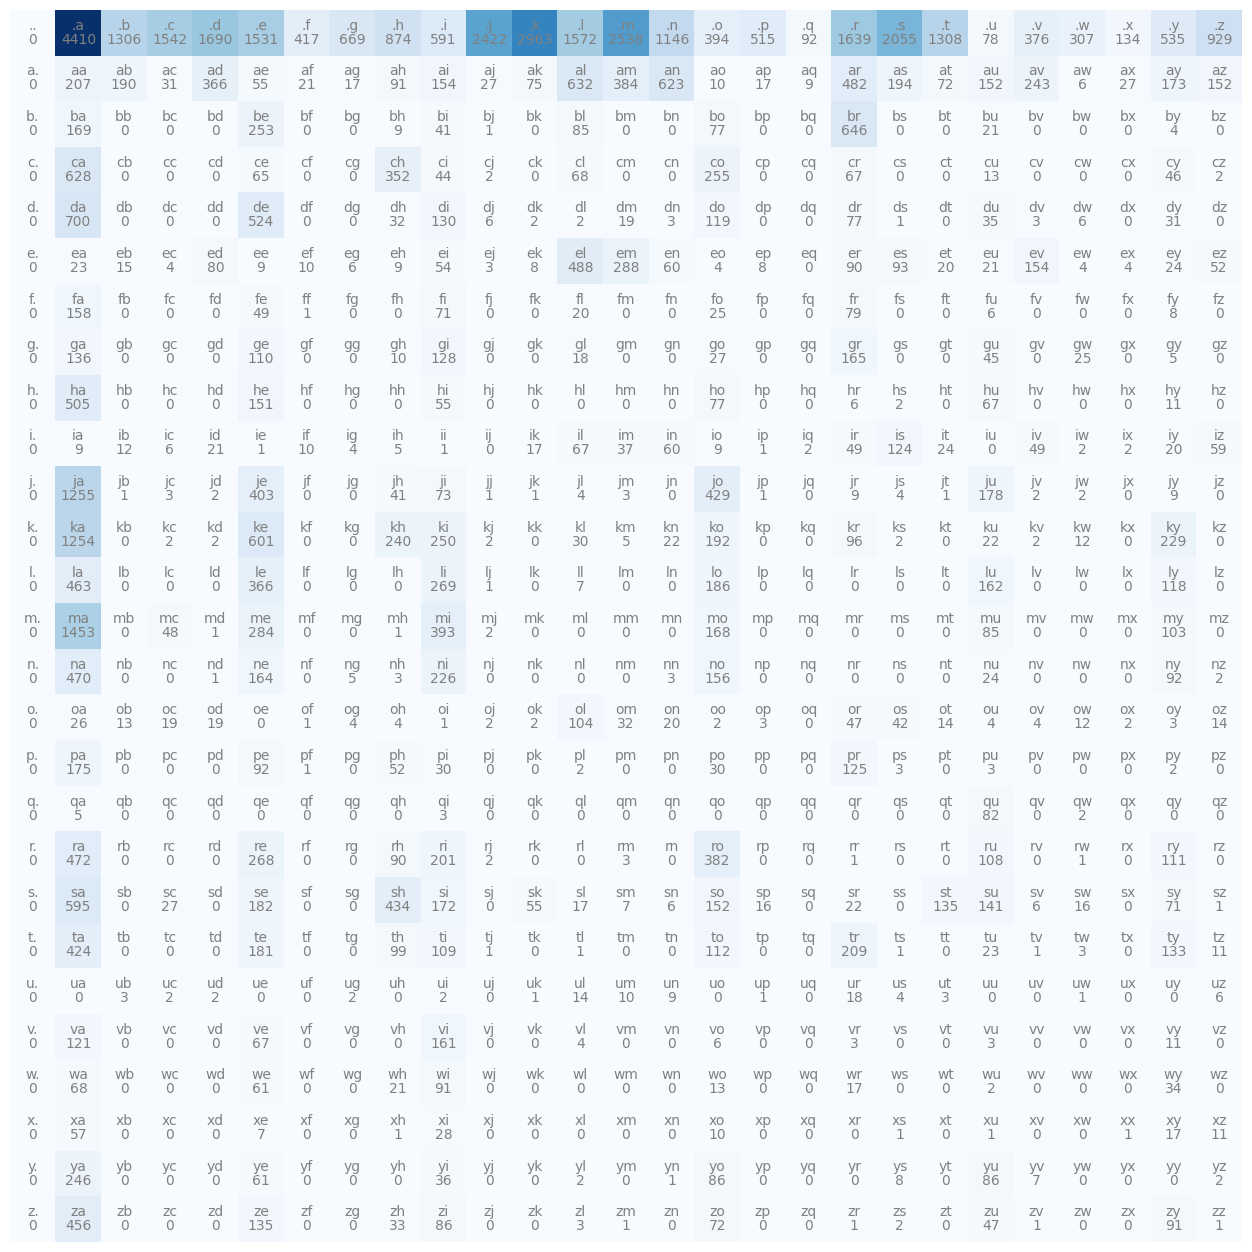

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N[0], cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[0,i,j].item(), ha='center', va='top', color='gray')
plt.axis("off")

In [6]:
p = N[0][1].float()
p = p / p.sum()
p

tensor([0.0000, 0.0469, 0.0431, 0.0070, 0.0830, 0.0125, 0.0048, 0.0039, 0.0206,
        0.0349, 0.0061, 0.0170, 0.1433, 0.0871, 0.1413, 0.0023, 0.0039, 0.0020,
        0.1093, 0.0440, 0.0163, 0.0345, 0.0551, 0.0014, 0.0061, 0.0392, 0.0345])

In [7]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix

4

In [8]:
P = (N + 1).float()
P = P / P.sum(2, keepdim=True)

In [9]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    ix1 = 0
    ix2 = 0
    out = []
    while True:
        p = P[ix1, ix2]
        ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1, ix2 = ix2, ix3

    print(''.join(out))

ce.
bra.
jalius.
rochityharlonimittain.
luwak.
ka.
da.
samiyah.
javer.
gotai.


In [10]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1][ix2][ix3]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
print(log_likelihood)
nll = -log_likelihood
print(nll/n)

tensor(-504653.)
tensor(2.2120)


In [11]:
#create training set
xs, zs, ys = [], [], []

for w in words[:1]:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        zs.append(ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
zs = torch.tensor(zs)
ys = torch.tensor(ys)


In [12]:
import torch.nn.functional as F
x1 = F.one_hot(xs, num_classes=27).float()
x2 = F.one_hot(zs, num_classes=27).float()
xenc = torch.cat([x1, x2], dim=1).float()

In [13]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g)

In [14]:
xenc.shape

torch.Size([5, 54])

In [15]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)  #NEED TO BE CLEAR, SOFTMAX

In [16]:
#create training set
xs, zs, ys = [], [], []

for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        zs.append(ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
zs = torch.tensor(zs)
ys = torch.tensor(ys)

num_examples = xs.size(0)
perm = torch.randperm(num_examples)

train_end = int(0.8 * num_examples)
dev_end = int(0.9 * num_examples)

train_idx = perm[:train_end]
dev_idx = perm[train_end:dev_end]
test_idx = perm[dev_end:]

xsTrain, zsTrain, ysTrain = xs[train_idx], zs[train_idx], ys[train_idx]
xsDev, zsDev, ysDev = xs[dev_idx], zs[dev_idx], ys[dev_idx]
xsTest, zsTest, ysTest = xs[test_idx], zs[test_idx], ys[test_idx]

numTrain = xsTrain.nelement()
numDev = xsDev.nelement()
numTest = xsTest.nelement()
print("num of examples: ", numTrain)

#init network
#init NN weights 27
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)



num of examples:  182516


In [18]:
for k in range(1000):
    #forward pass
    x1 = F.one_hot(xsTrain, num_classes=27).float()
    x2 = F.one_hot(zsTrain, num_classes=27).float()
    xenc = torch.cat([x1, x2], dim=1).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/ counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(numTrain), ysTrain].log().mean()
    print(loss.item())

    #backward pass
    W.grad = None
    loss.backward()

    #update weights
    W.data += -10*W.grad

2.4810593128204346
2.479705572128296
2.4783759117126465
2.477069139480591
2.475785255432129
2.474522829055786
2.4732820987701416
2.472062110900879
2.47086238861084
2.4696826934814453
2.4685218334198
2.4673798084259033
2.466256856918335
2.465151071548462
2.4640631675720215
2.4629921913146973
2.461937665939331
2.460899591445923
2.4598774909973145
2.4588711261749268
2.4578793048858643
2.456902503967285
2.4559404850006104
2.4549922943115234
2.4540581703186035
2.4531373977661133
2.452230215072632
2.4513356685638428
2.450453996658325
2.4495849609375
2.44872784614563
2.4478824138641357
2.447049140930176
2.4462270736694336
2.44541597366333
2.4446160793304443
2.443826913833618
2.4430482387542725
2.442279815673828
2.441521644592285
2.4407732486724854
2.440035104751587
2.4393057823181152
2.4385862350463867
2.437875509262085
2.437174081802368
2.4364817142486572
2.435797691345215
2.43512225151062
2.434455156326294
2.4337961673736572
2.433145523071289
2.432502508163452
2.4318673610687256
2.431240081

In [21]:
g = torch.Generator().manual_seed(2147483647)

for i in range(40):
    out = []
    ix1, ix2 = 0, 0
    while True:
        x1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat([x1, x2], dim=1).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        ix3 = torch.multinomial(p[0], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix3])
        if ix3 == 0:
            break
        ix1, ix2 = ix2, ix3

    print(''.join(out))


cexze.
morlyurailaziaydamellimittain.
lusan.
ka.
da.
samiyaubrtthrigotai.
morielliausie.
teda.
kaleyla.
sade.
enkavirny.
fobspih.
ciden.
tahlasu.
jadr.
breegl.
peig.
iatta.
ra.
dinne.
zam.
der.
jair.
the.
ckayshaabsamah.
kurileelleyanimelyh.
keen.
xmal.
kalmie.
vay.
ca.
mysor.
laiten.
miengerisaifyen.
kyille.
llh.
id.
meenisammikamaxem.
keisharis.
alcalhy.


In [19]:
x1 = F.one_hot(xsDev, num_classes=27).float()
x2 = F.one_hot(zsDev, num_classes=27).float()
xenc = torch.cat([x1, x2], dim=1).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/ counts.sum(1, keepdim=True)
loss = -probs[torch.arange(numDev), ysDev].log().mean()
print(loss.item())

2.3480985164642334


In [20]:
x1 = F.one_hot(xsTest, num_classes=27).float()
x2 = F.one_hot(zsTest, num_classes=27).float()
xenc = torch.cat([x1, x2], dim=1).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/ counts.sum(1, keepdim=True)
loss = -probs[torch.arange(numTest), ysTest].log().mean()
print(loss.item())

2.3510935306549072


(np.float64(-0.5), np.float64(26.5), np.float64(53.5), np.float64(-0.5))

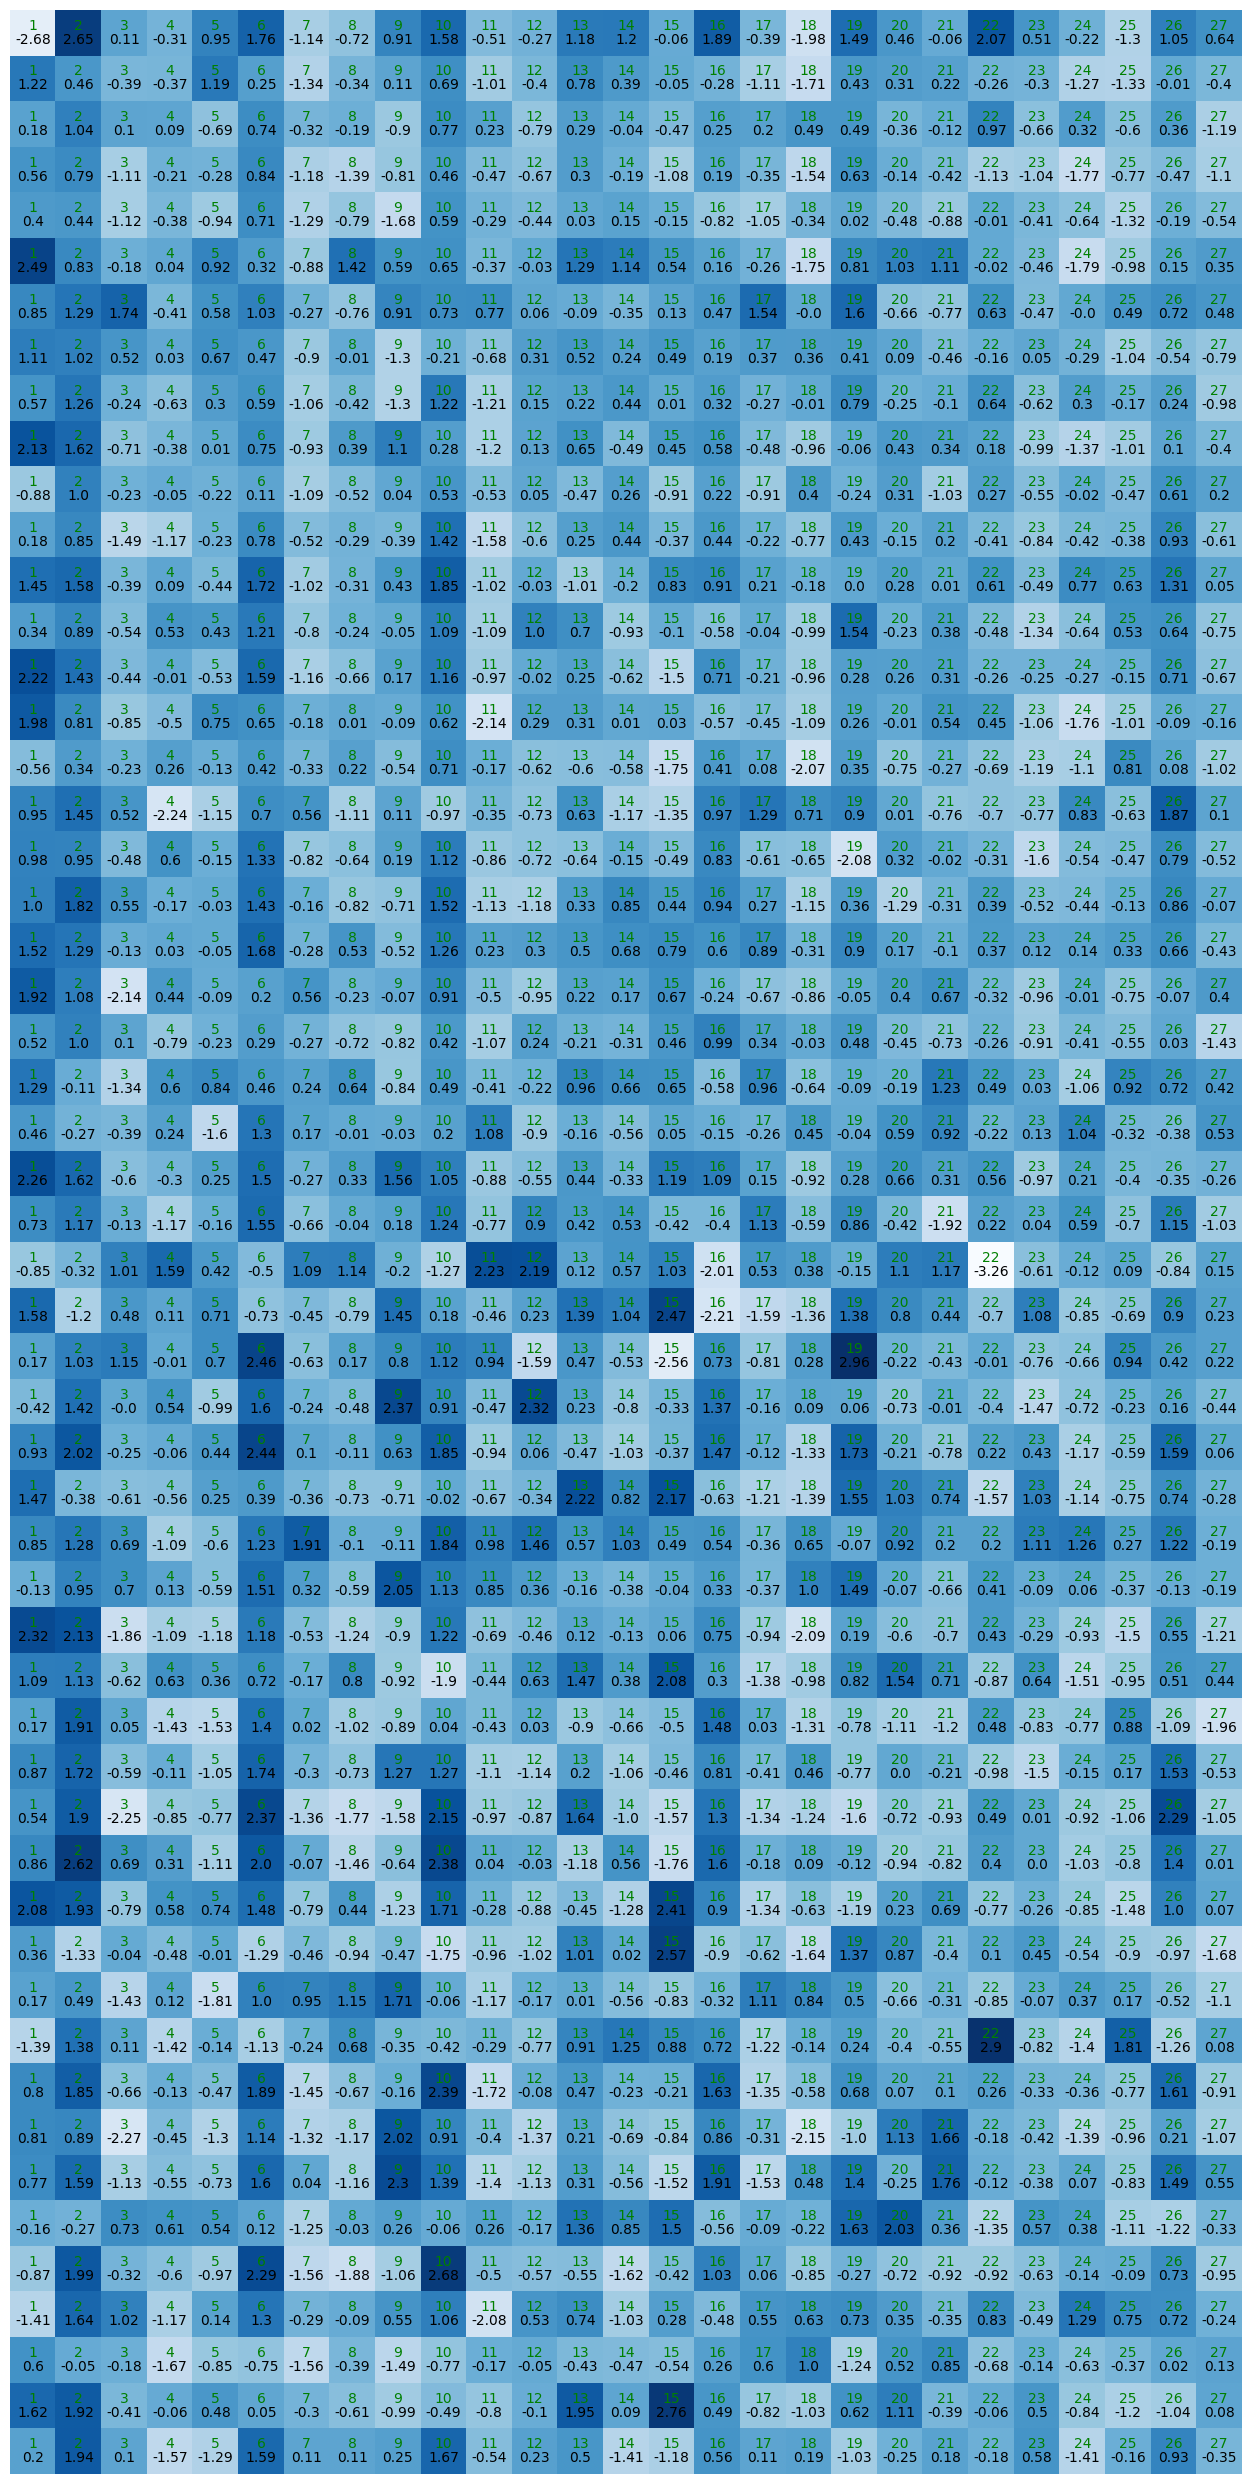

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(32,32))
plt.imshow(W.detach().numpy(), cmap='Blues')
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        plt.text(j, i, f"{j+1}", ha='center', va='bottom', color='green')
        plt.text(j, i, round(W[i,j].item(), 2), ha='center', va='top', color='black')
plt.axis("off")

In [66]:
W.shape

torch.Size([54, 27])

üé¨ –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–ª–æ–≤–∞:


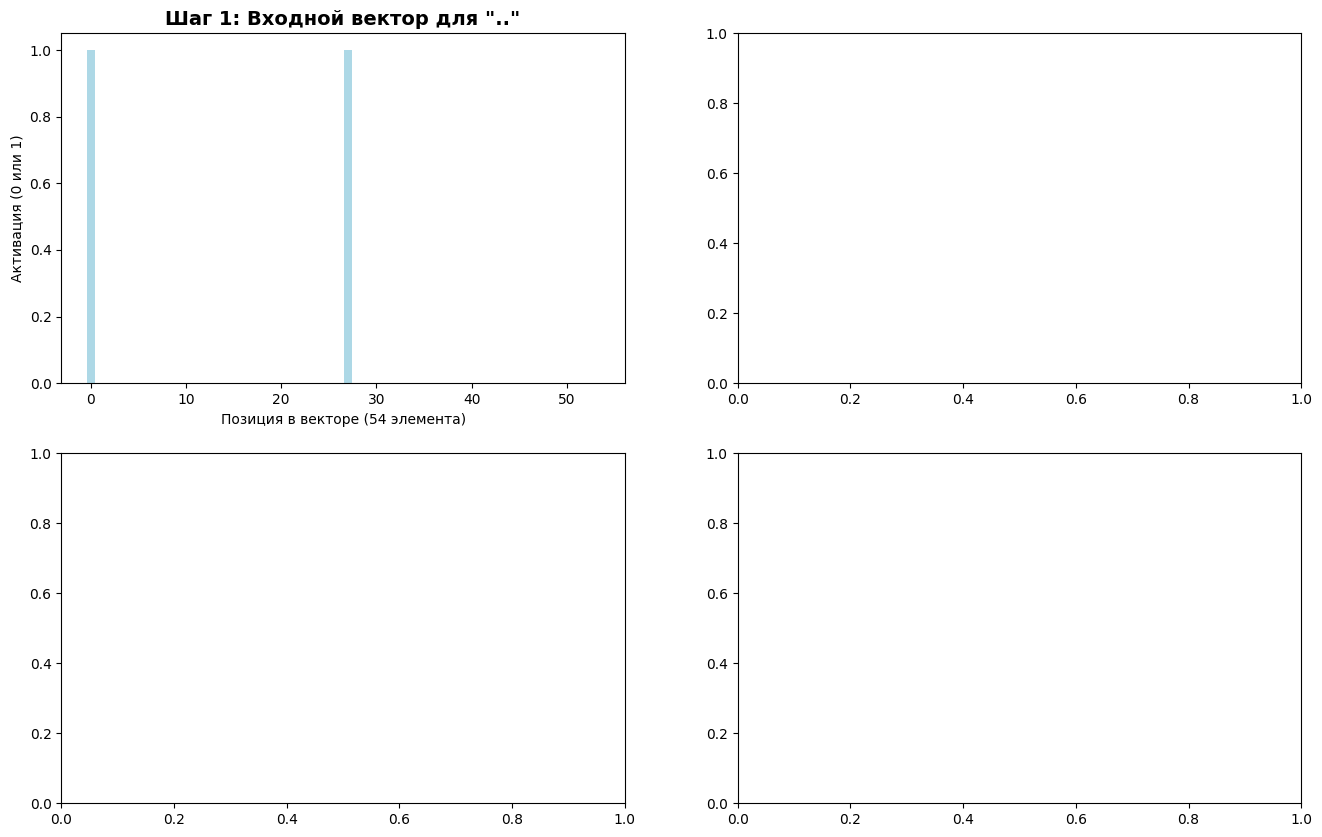

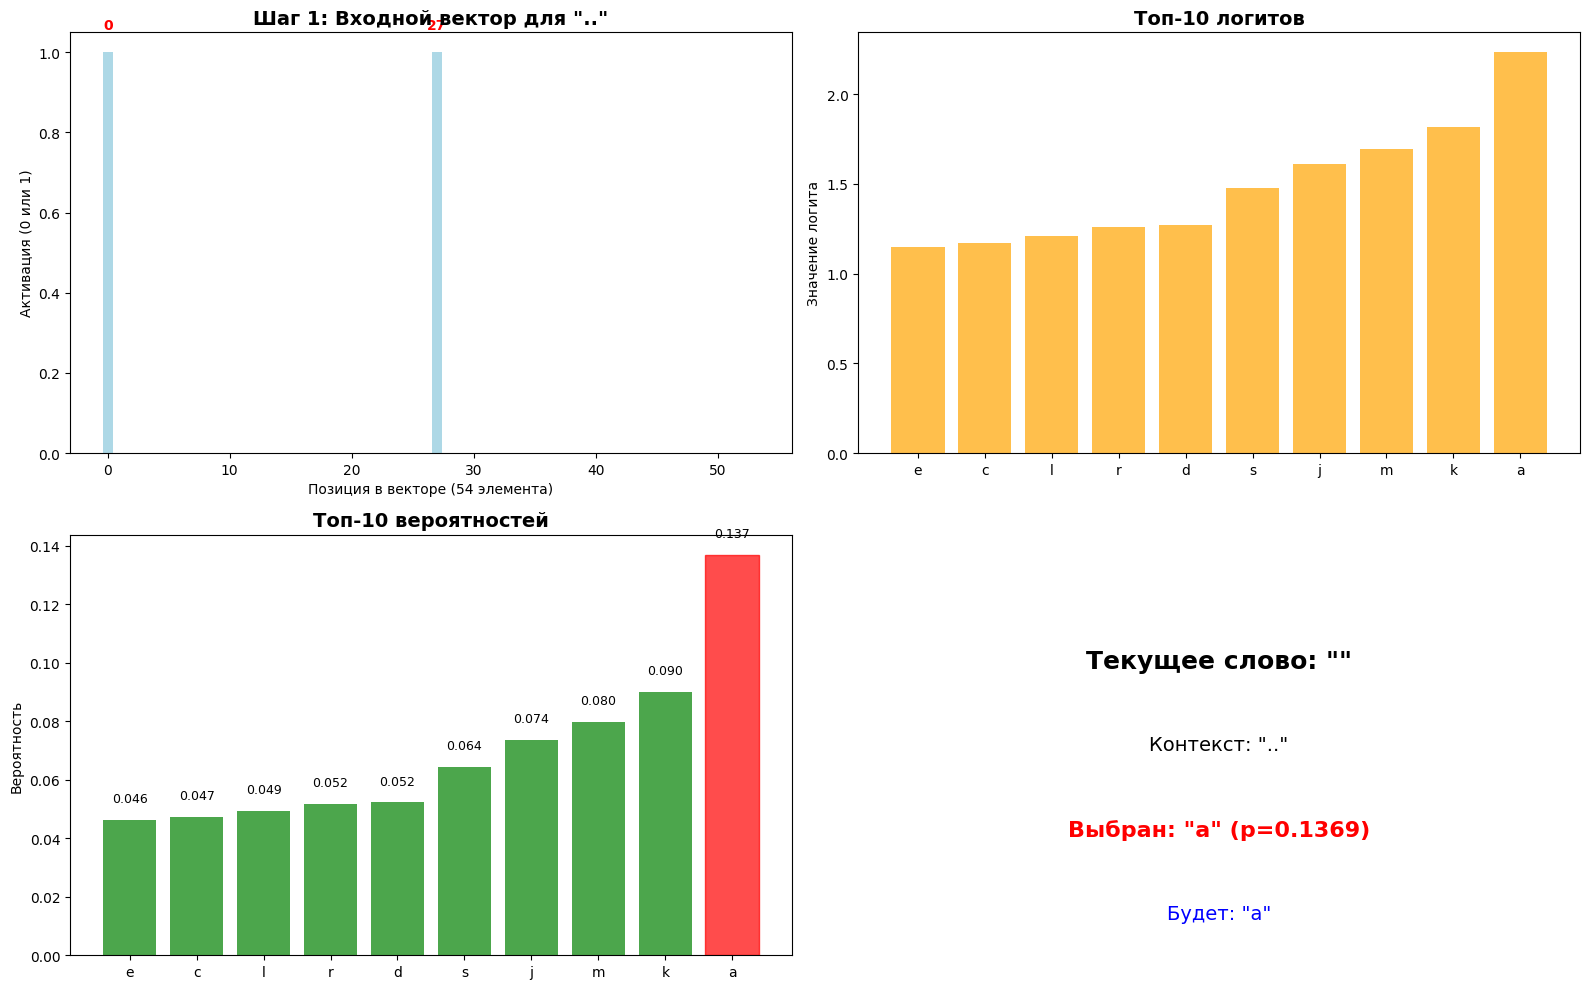


–®–∞–≥ 1:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: '..'
  –í—ã–±—Ä–∞–Ω: 'a' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.1369)
  –°–ª–æ–≤–æ: '' ‚Üí 'a'


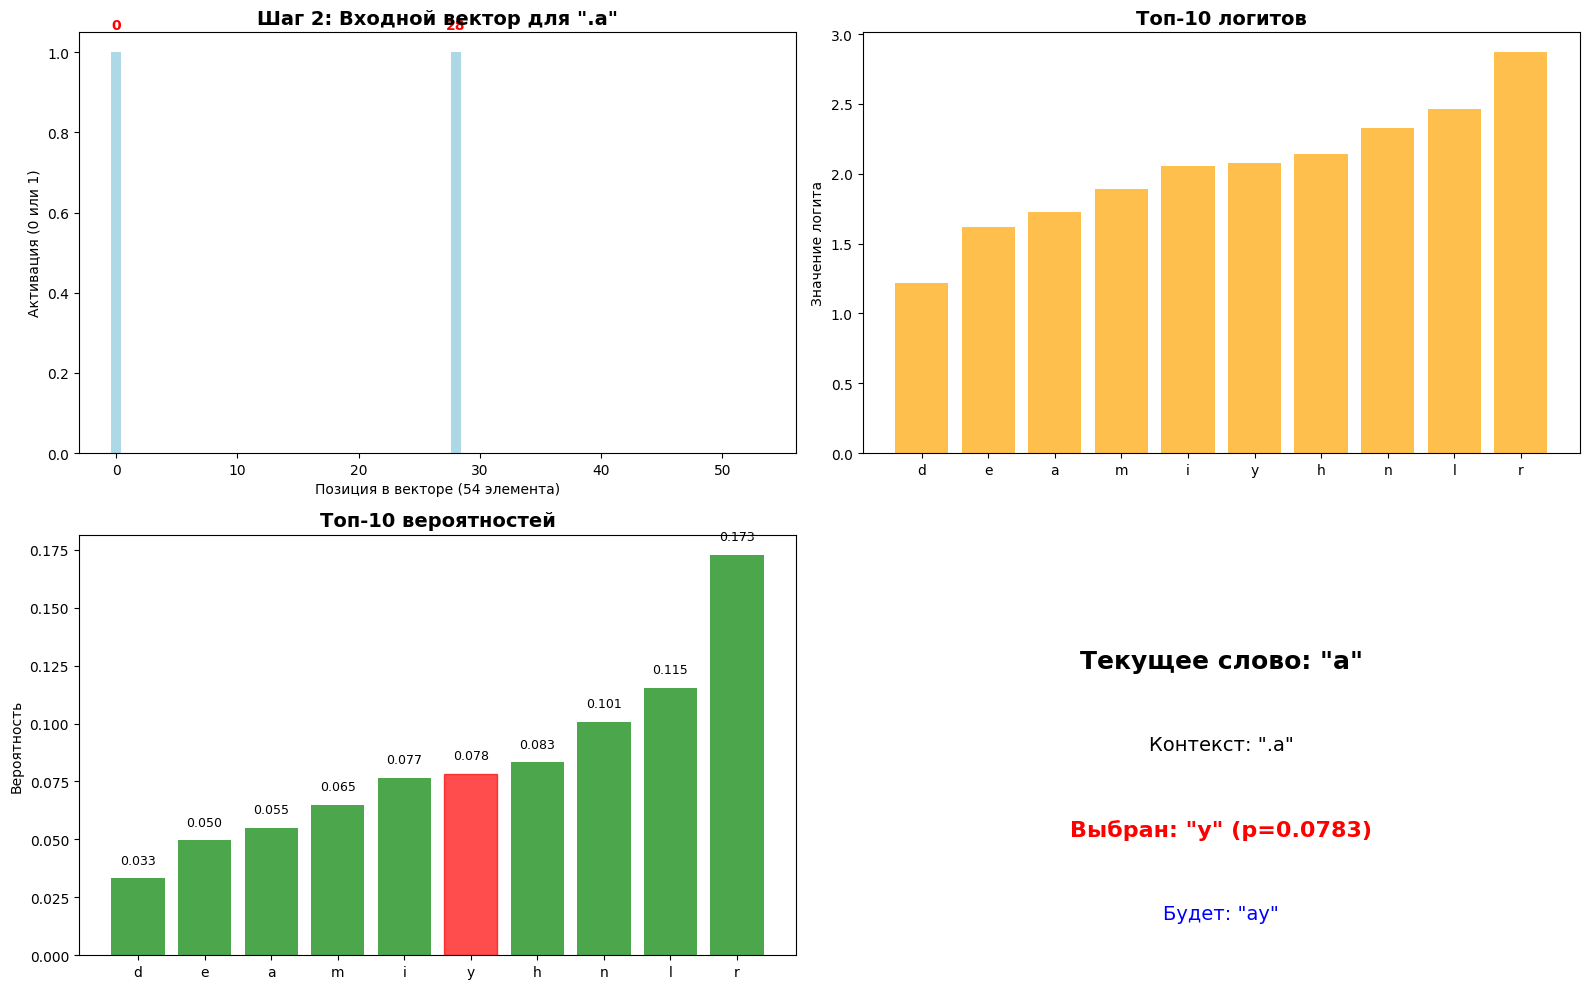


–®–∞–≥ 2:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: '.a'
  –í—ã–±—Ä–∞–Ω: 'y' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0783)
  –°–ª–æ–≤–æ: 'a' ‚Üí 'ay'


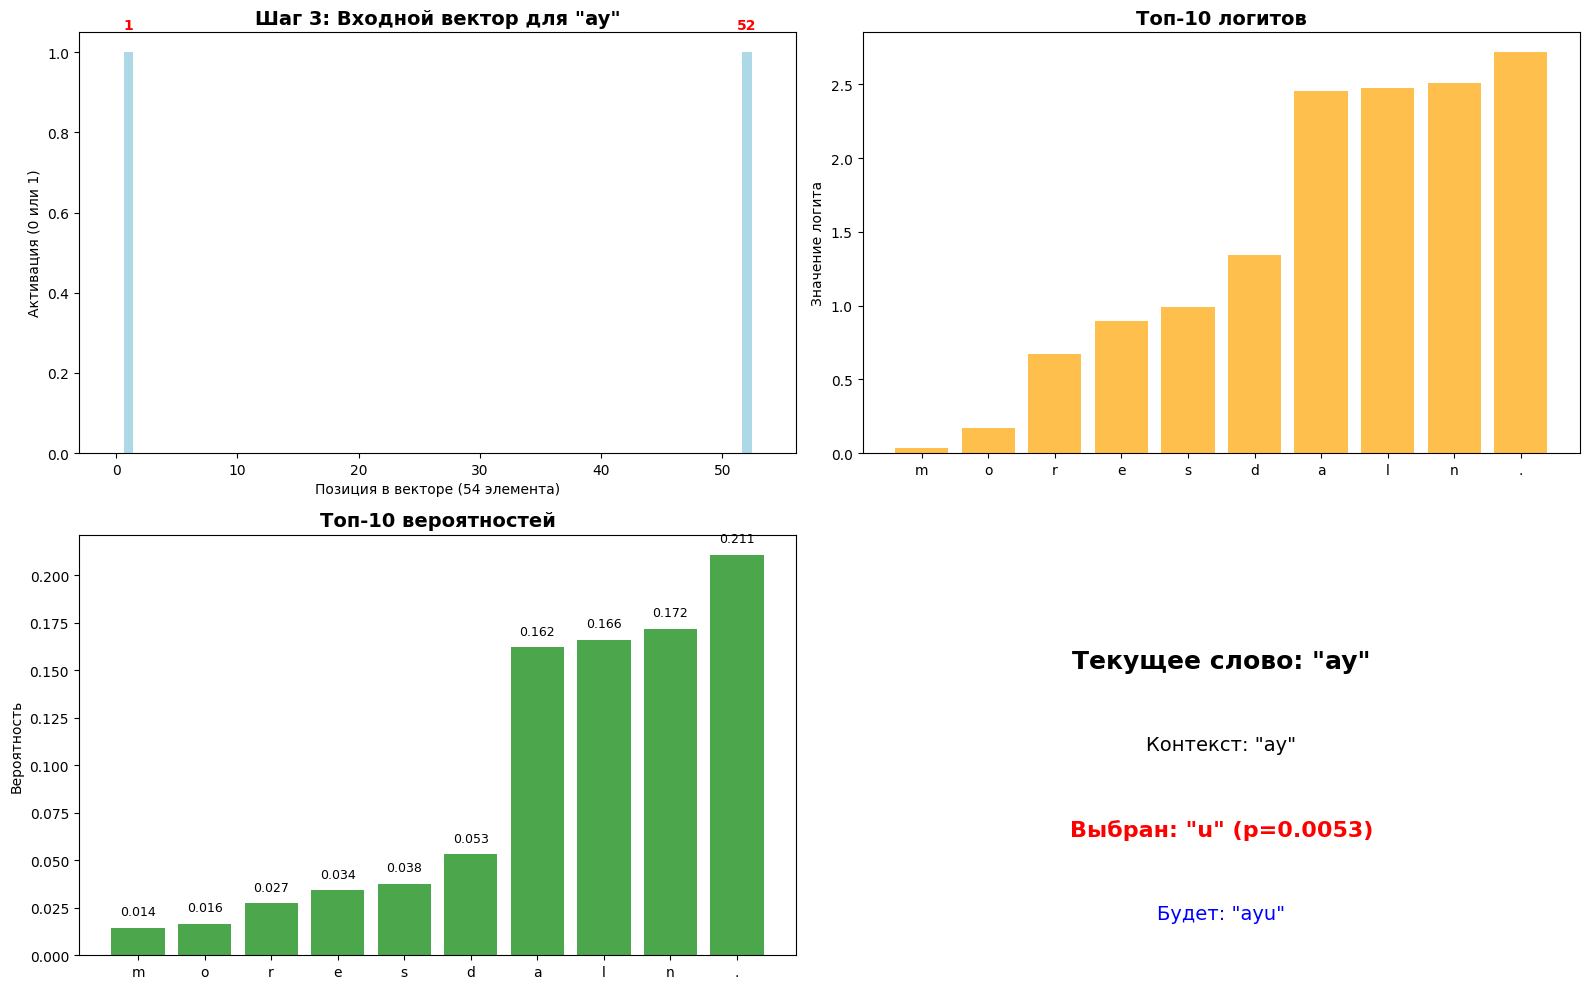


–®–∞–≥ 3:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'ay'
  –í—ã–±—Ä–∞–Ω: 'u' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0053)
  –°–ª–æ–≤–æ: 'ay' ‚Üí 'ayu'


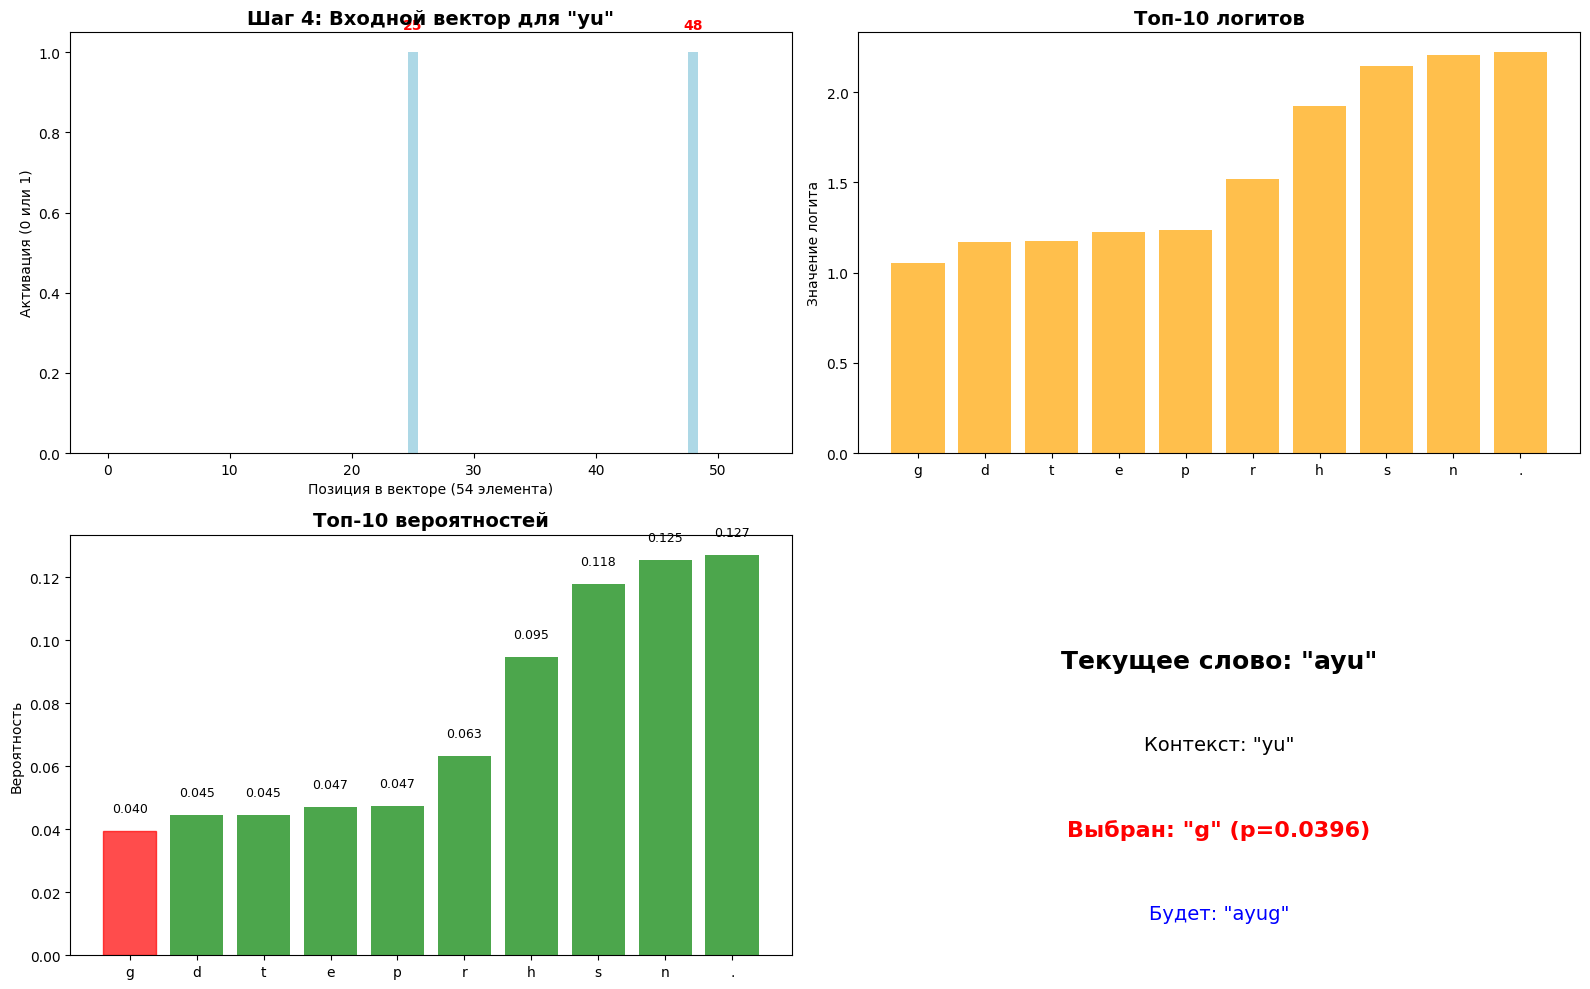


–®–∞–≥ 4:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'yu'
  –í—ã–±—Ä–∞–Ω: 'g' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0396)
  –°–ª–æ–≤–æ: 'ayu' ‚Üí 'ayug'


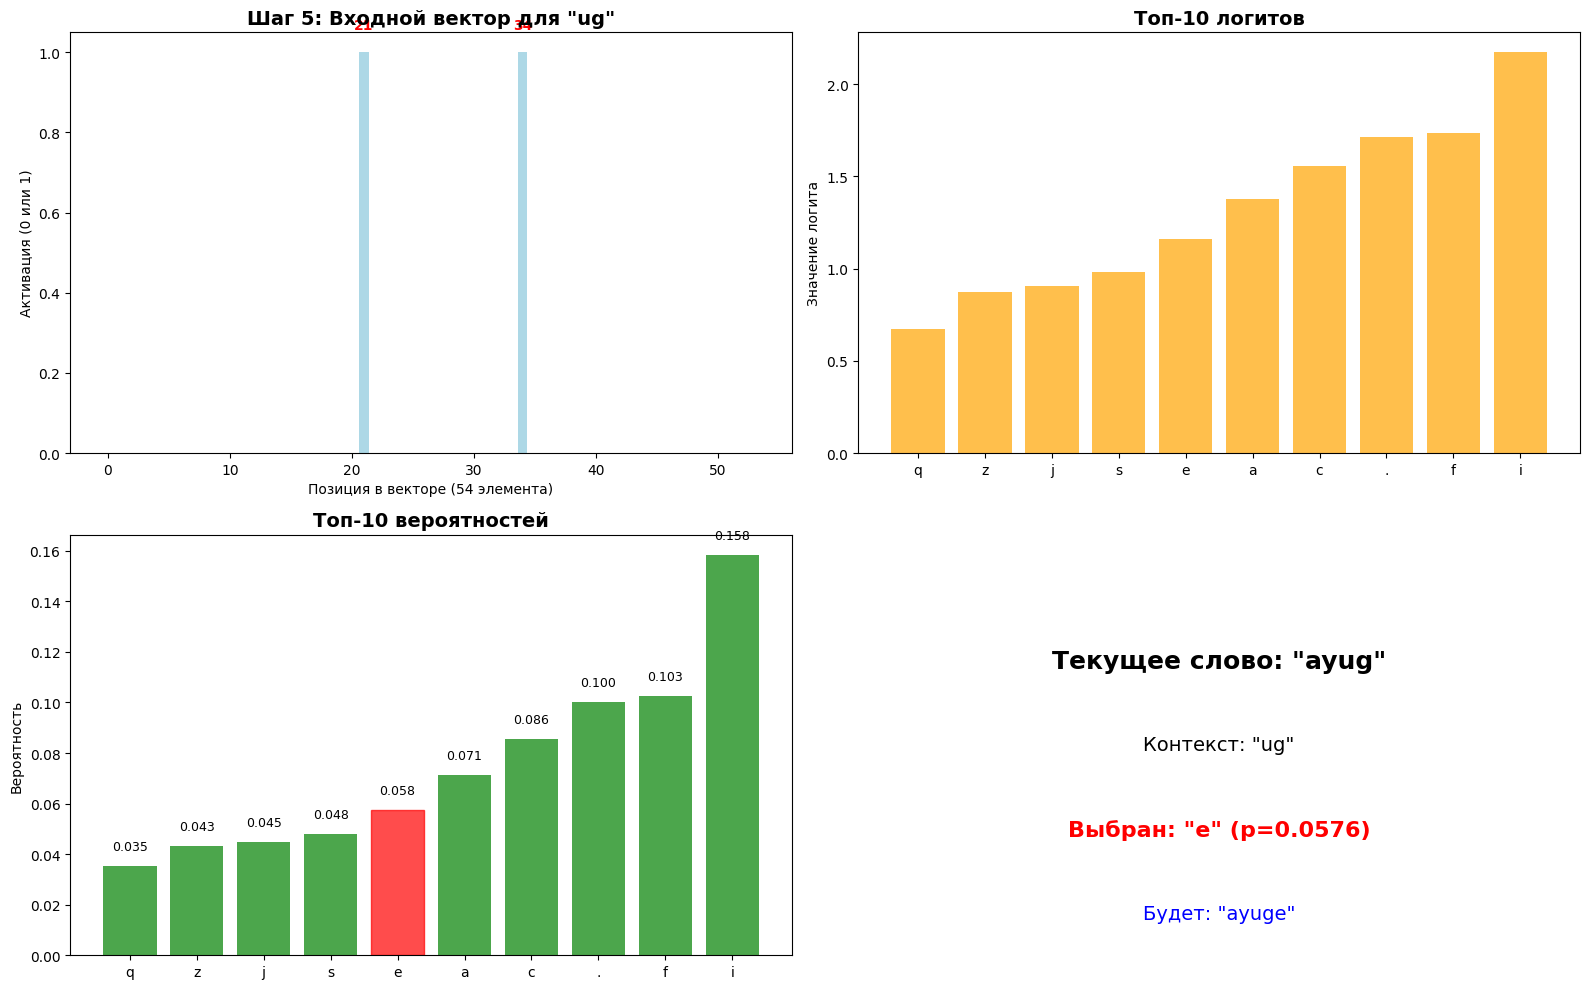


–®–∞–≥ 5:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'ug'
  –í—ã–±—Ä–∞–Ω: 'e' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0576)
  –°–ª–æ–≤–æ: 'ayug' ‚Üí 'ayuge'


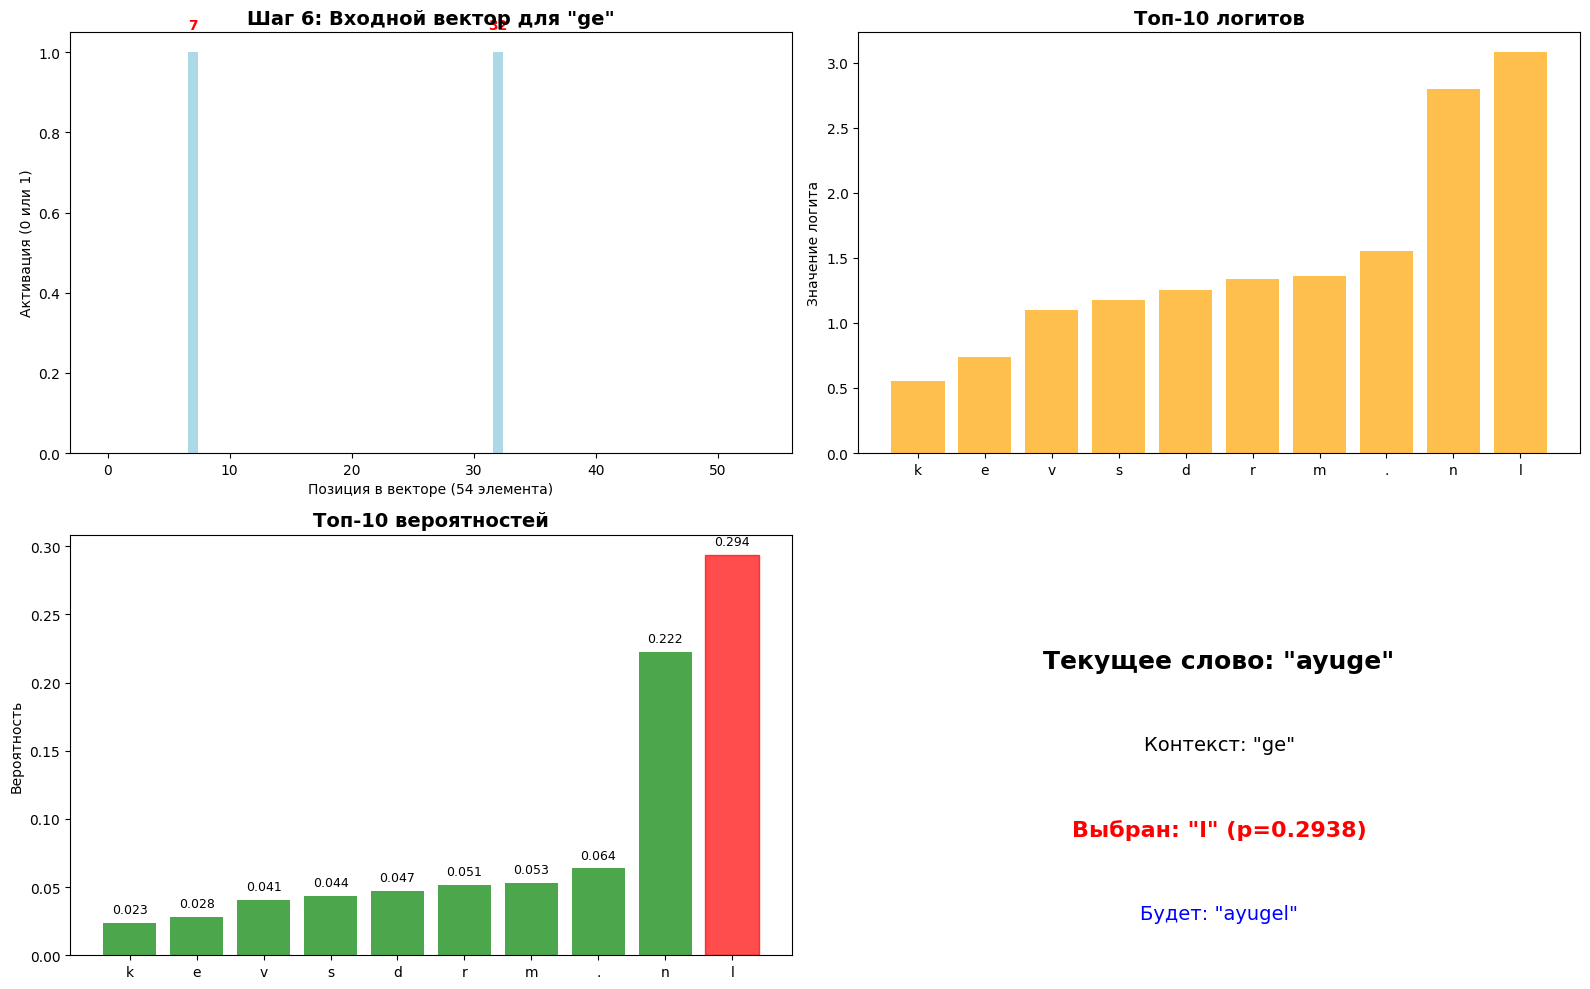


–®–∞–≥ 6:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'ge'
  –í—ã–±—Ä–∞–Ω: 'l' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.2938)
  –°–ª–æ–≤–æ: 'ayuge' ‚Üí 'ayugel'


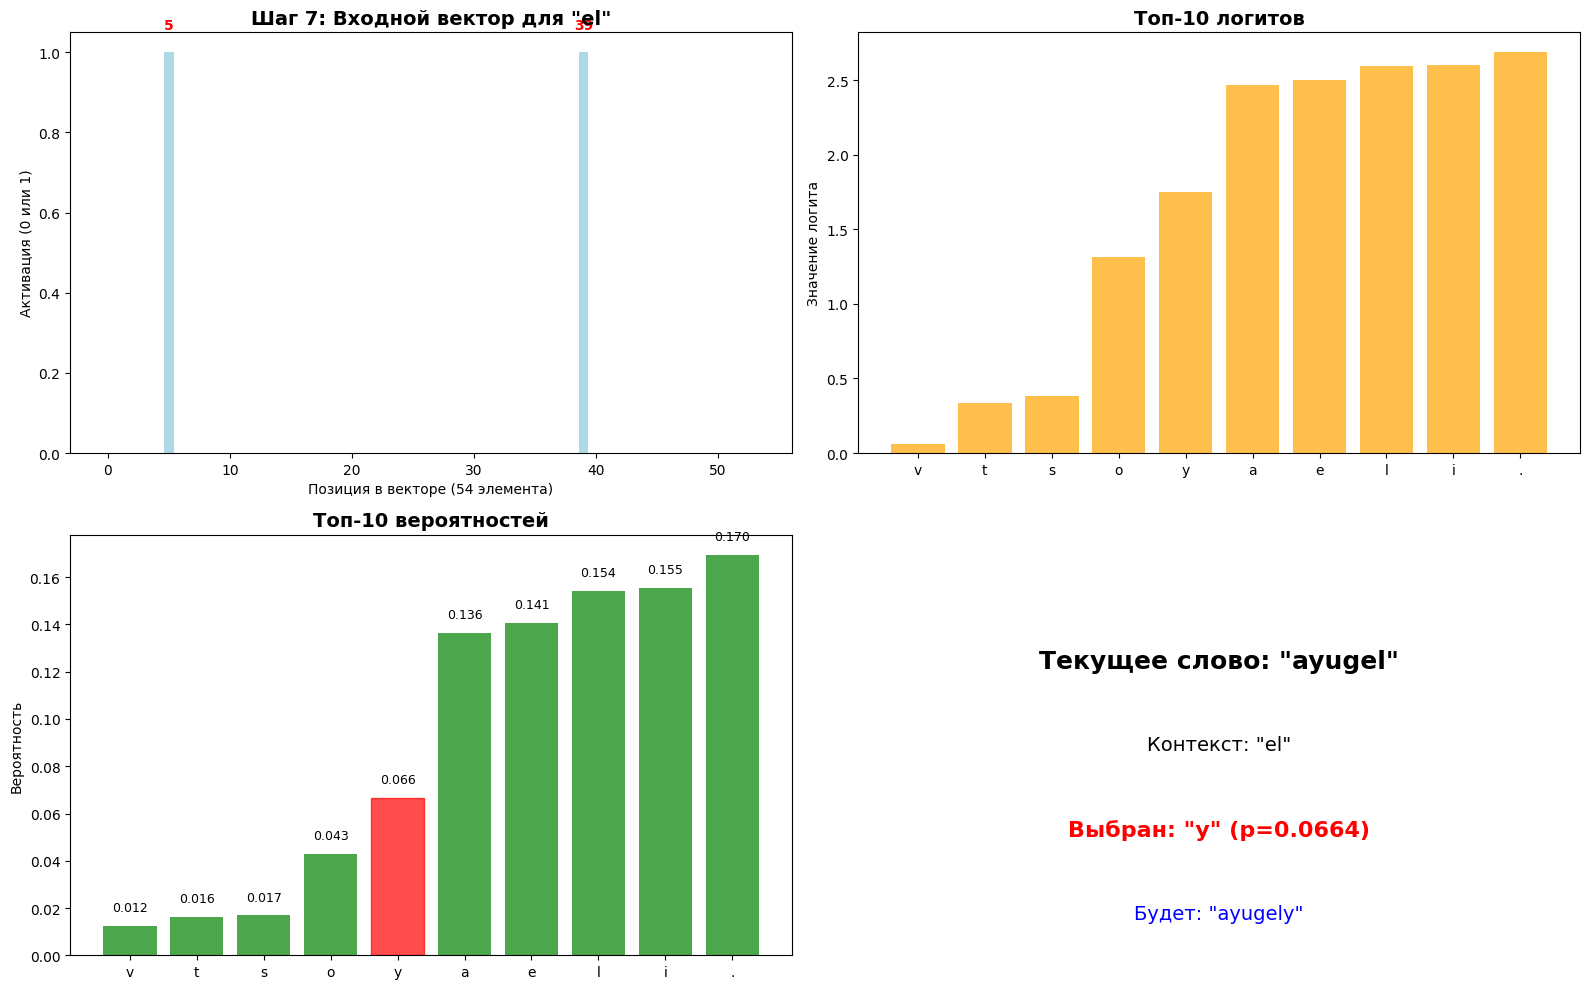


–®–∞–≥ 7:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'el'
  –í—ã–±—Ä–∞–Ω: 'y' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0664)
  –°–ª–æ–≤–æ: 'ayugel' ‚Üí 'ayugely'


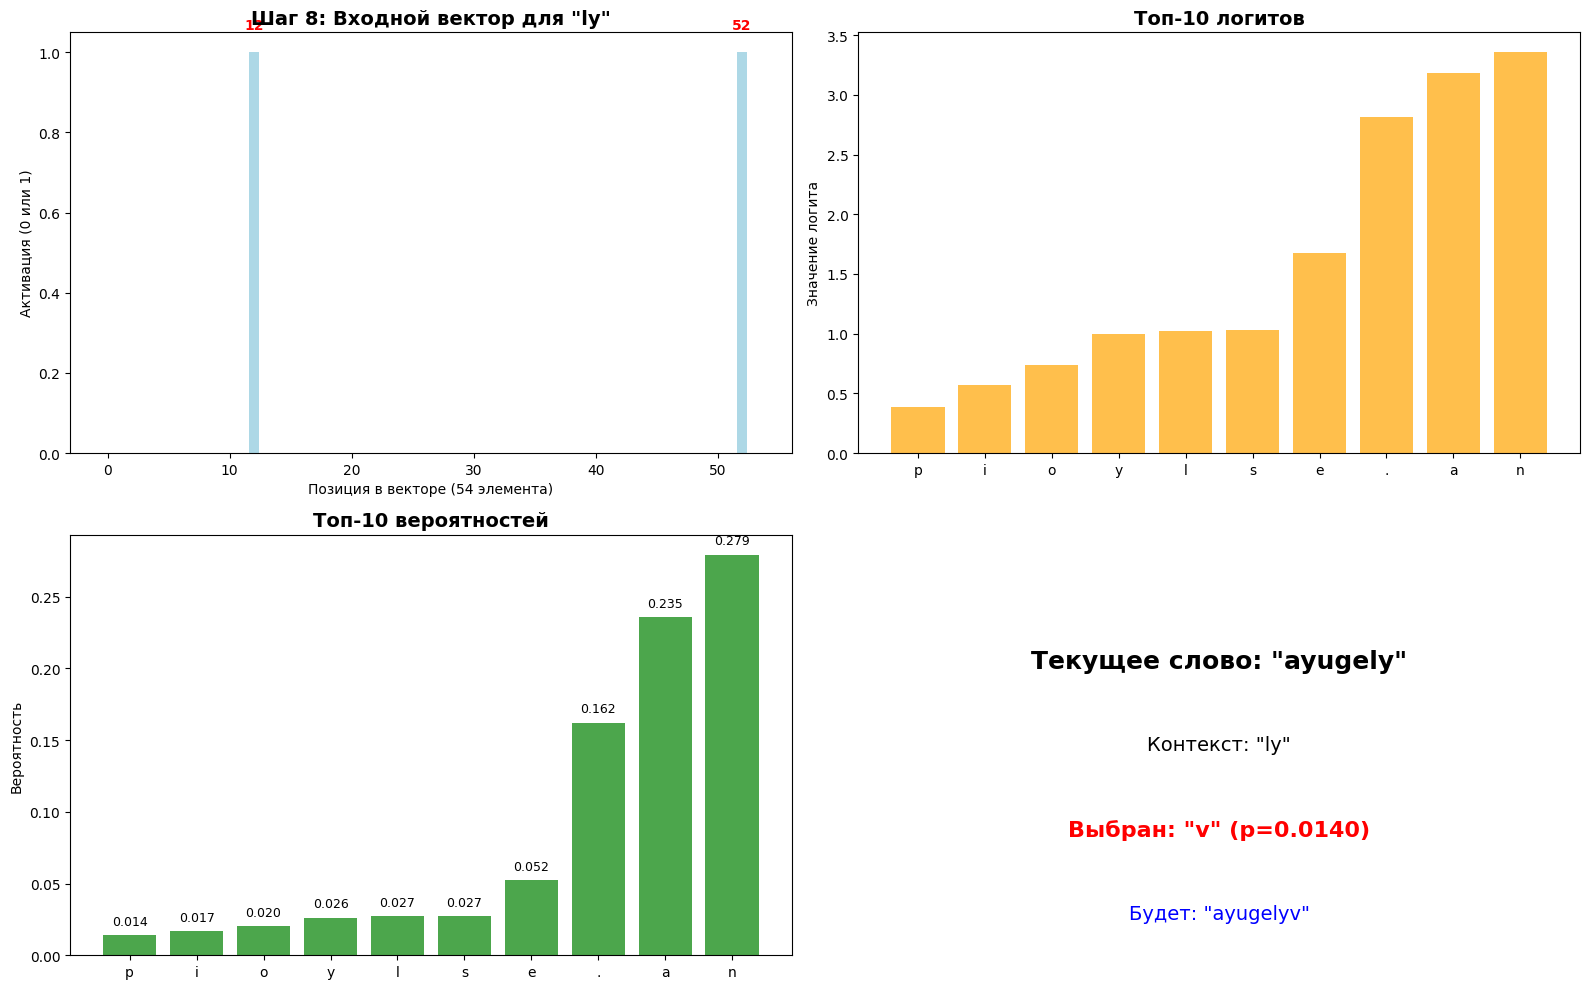


–®–∞–≥ 8:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'ly'
  –í—ã–±—Ä–∞–Ω: 'v' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0140)
  –°–ª–æ–≤–æ: 'ayugely' ‚Üí 'ayugelyv'


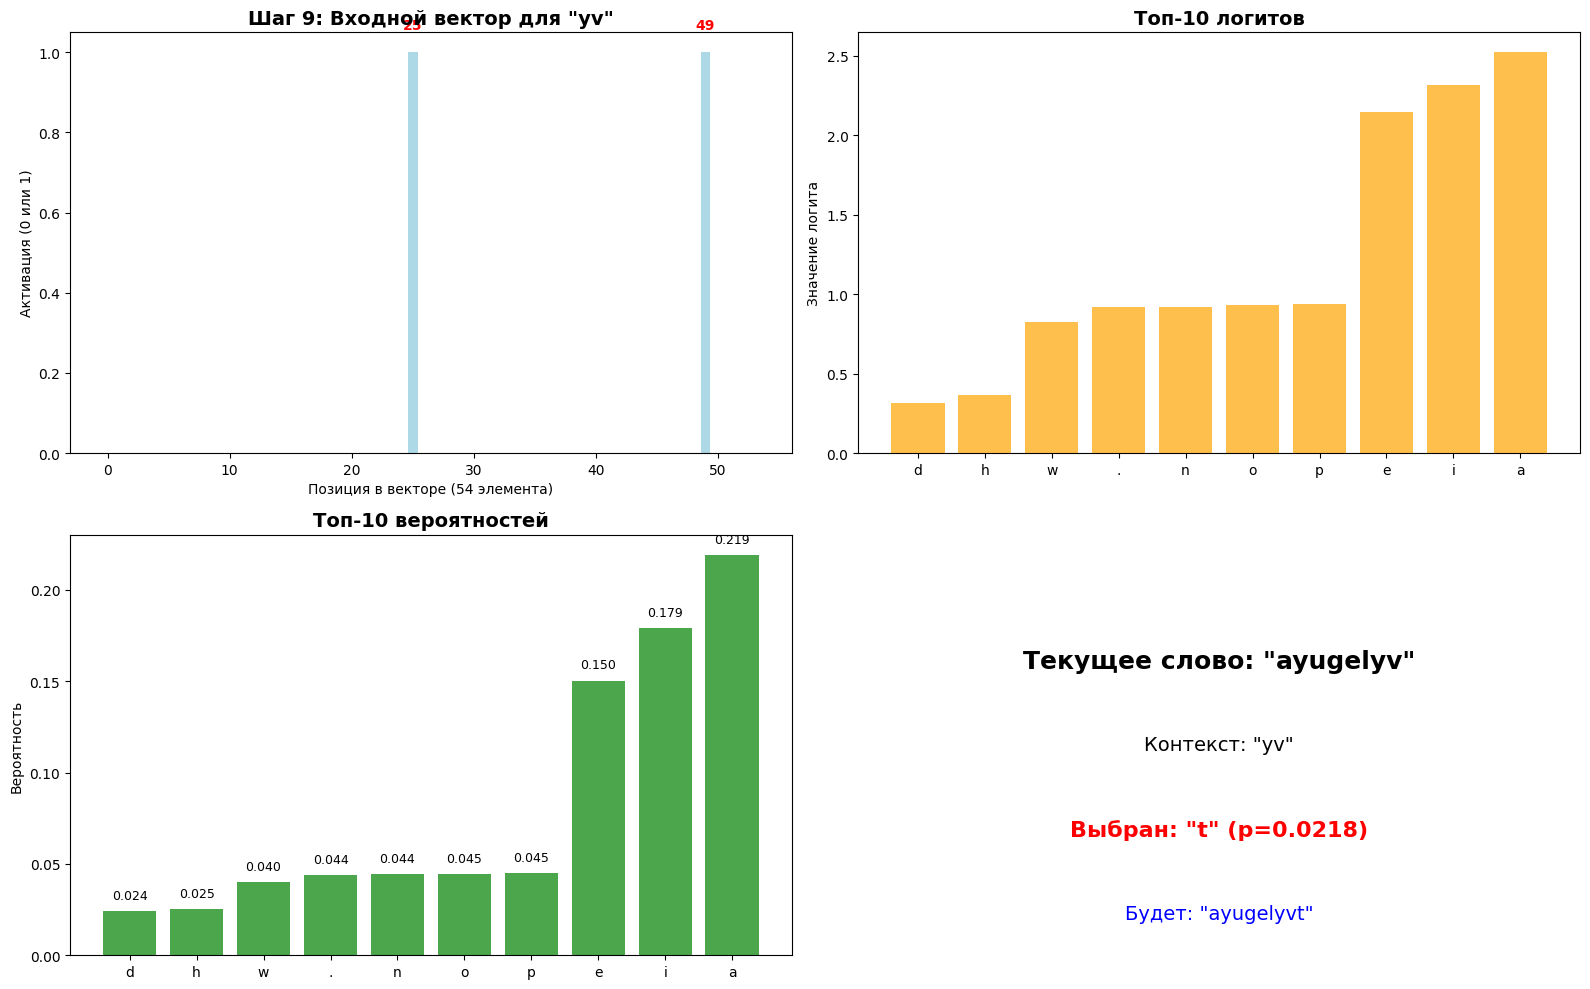


–®–∞–≥ 9:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'yv'
  –í—ã–±—Ä–∞–Ω: 't' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0218)
  –°–ª–æ–≤–æ: 'ayugelyv' ‚Üí 'ayugelyvt'


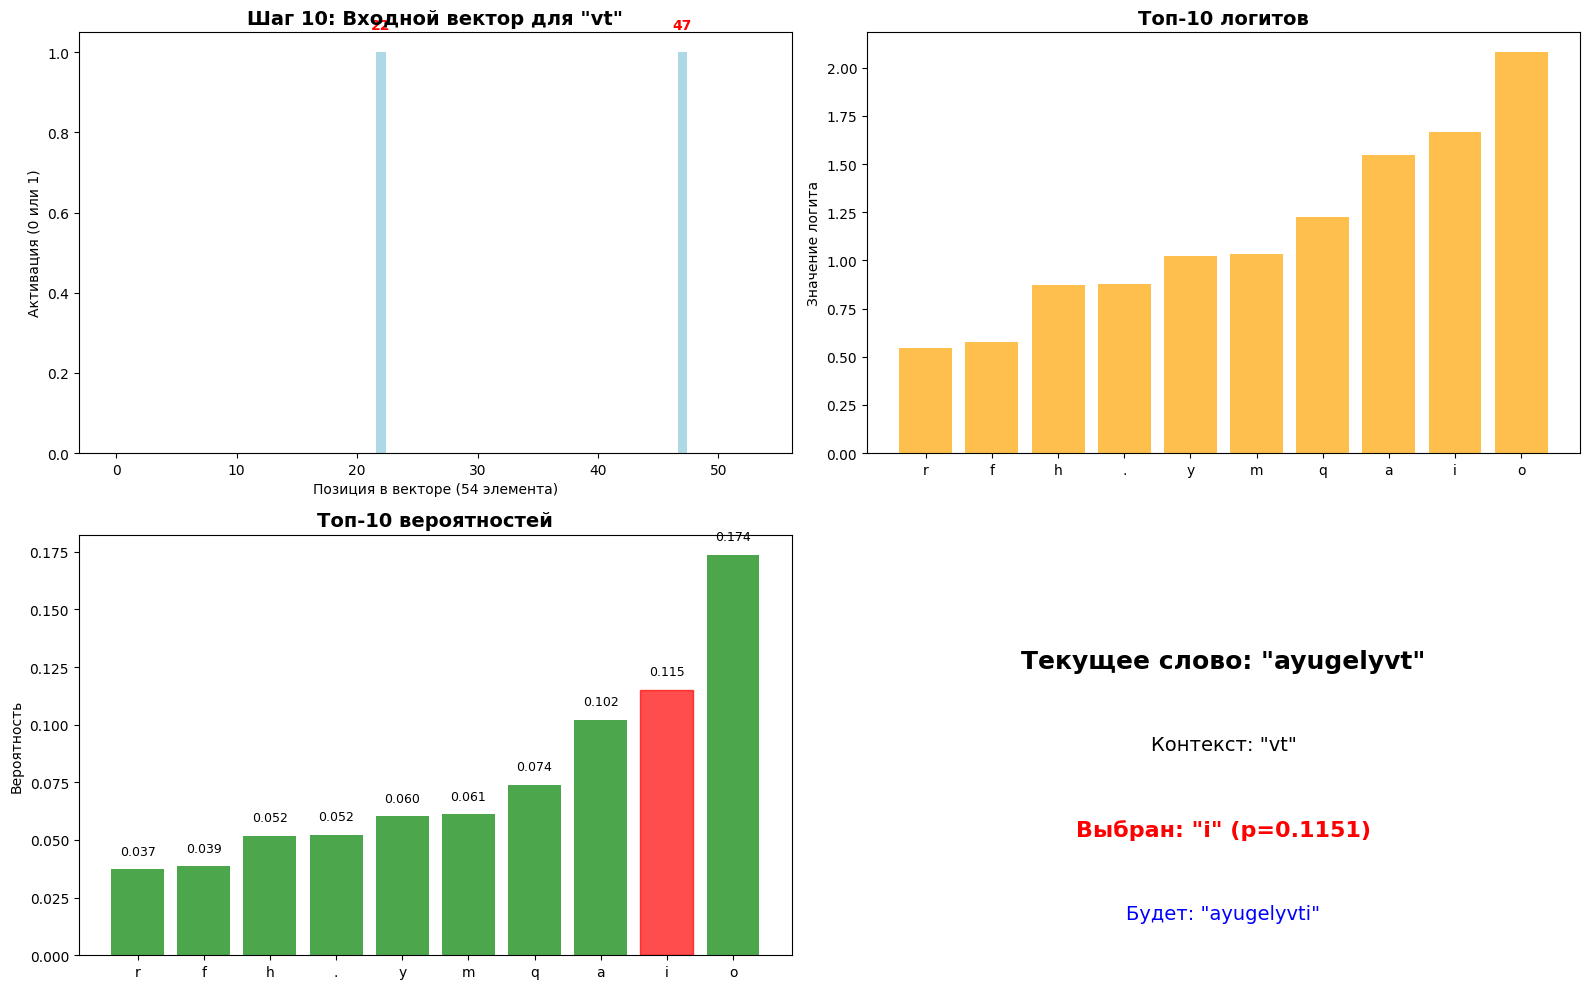


–®–∞–≥ 10:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'vt'
  –í—ã–±—Ä–∞–Ω: 'i' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.1151)
  –°–ª–æ–≤–æ: 'ayugelyvt' ‚Üí 'ayugelyvti'


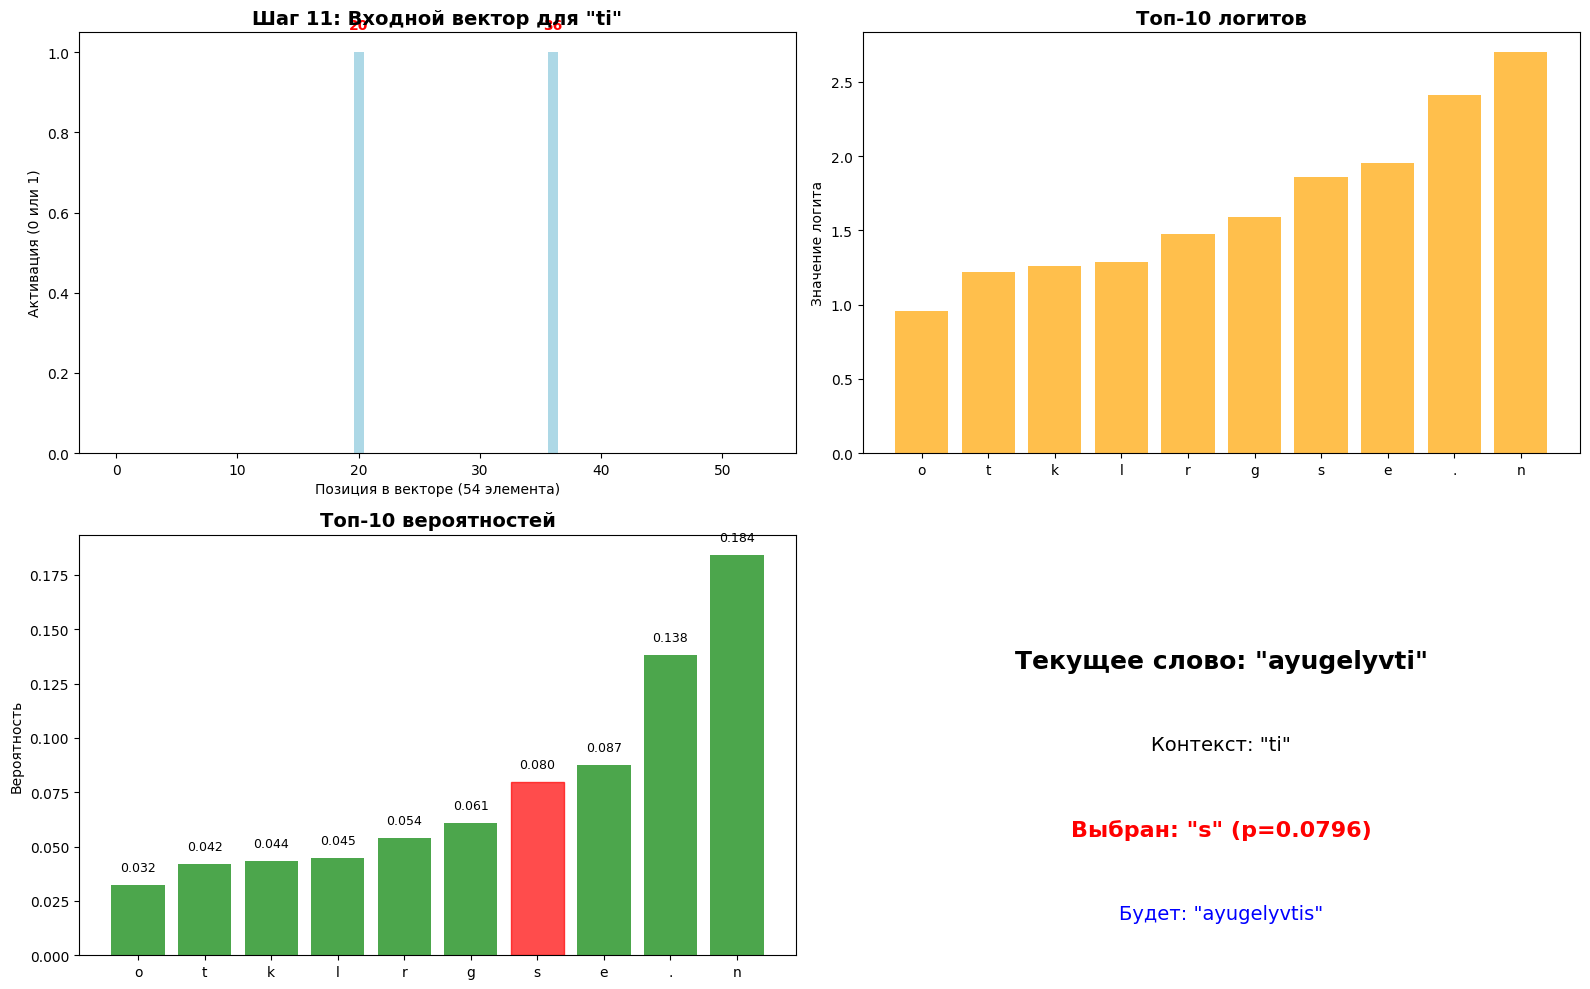


–®–∞–≥ 11:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'ti'
  –í—ã–±—Ä–∞–Ω: 's' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.0796)
  –°–ª–æ–≤–æ: 'ayugelyvti' ‚Üí 'ayugelyvtis'


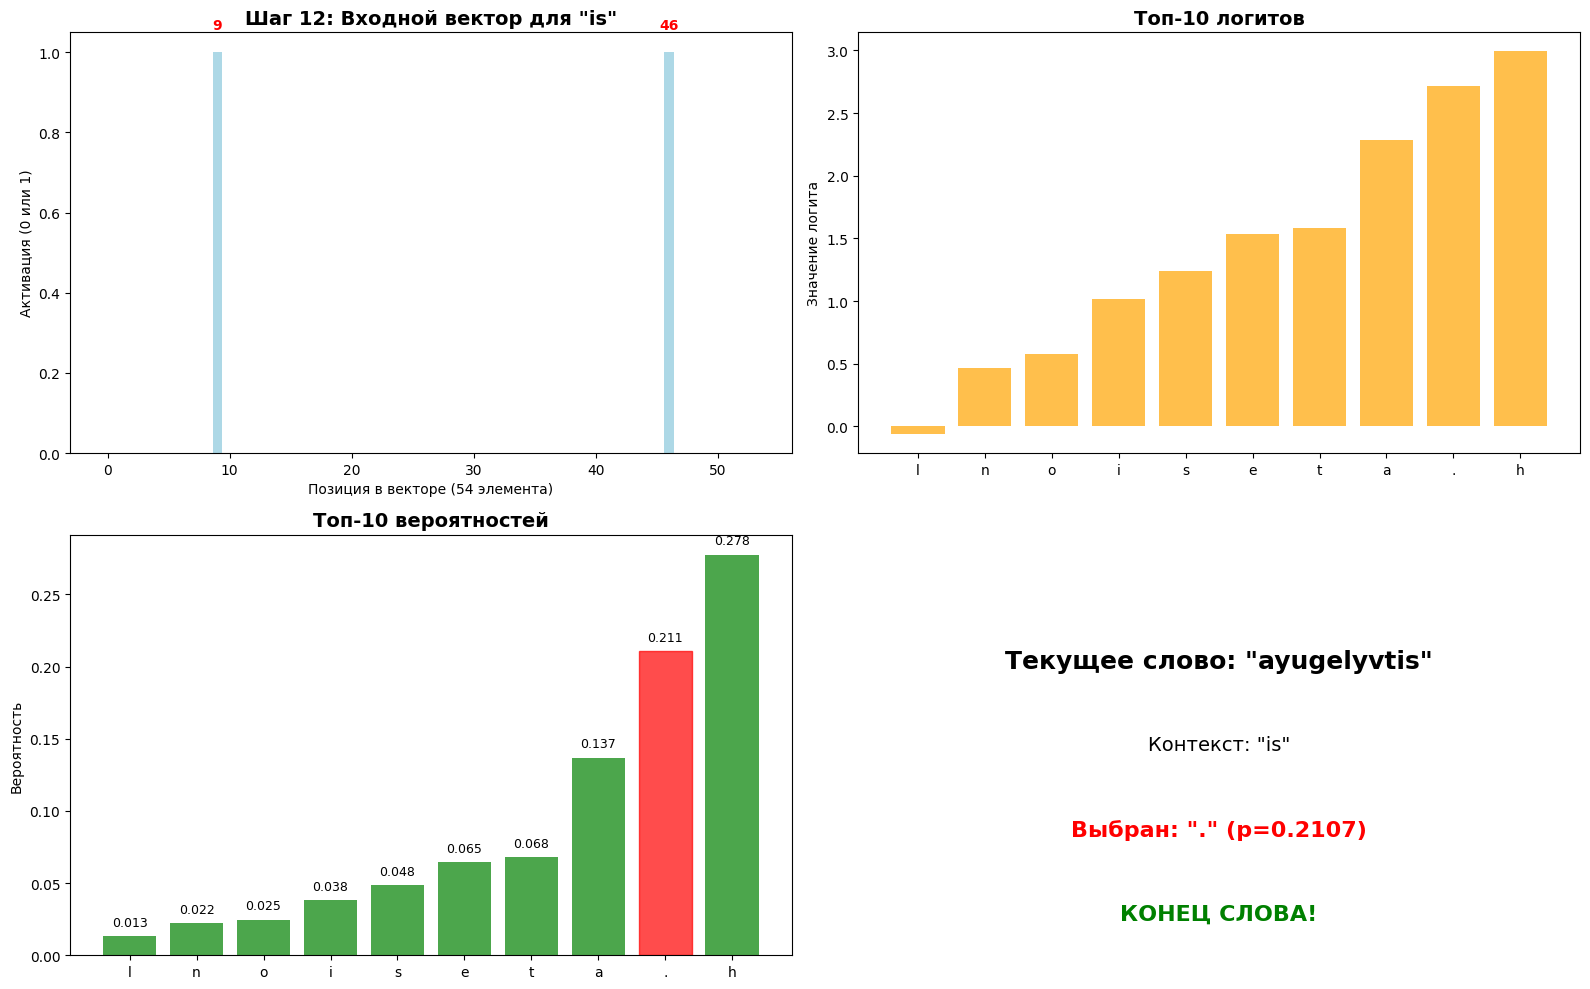


–®–∞–≥ 12:
  –ö–æ–Ω—Ç–µ–∫—Å—Ç: 'is'
  –í—ã–±—Ä–∞–Ω: '.' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.2107)
  –°–ª–æ–≤–æ: 'ayugelyvtis' ‚Üí 'ayugelyvtis'

üéâ –§–∏–Ω–∞–ª—å–Ω–æ–µ —Å–ª–æ–≤–æ: 'ayugelyvtis'


In [101]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import time


def visualize_word_generation(W, stoi, itos, seed=2147483647):
    g = torch.Generator().manual_seed(seed)

    ix1, ix2 = 0, 0  # start with '.', '.'
    generated_word = []
    step = 0

    print("üé¨ –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–ª–æ–≤–∞:")
    print("=" * 60)

    while True:
        step += 1

        # Forward pass
        x1 = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
        x2 = F.one_hot(torch.tensor([ix2]), num_classes=27).float()
        xenc = torch.cat([x1, x2], dim=1).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)

        # –°–æ–∑–¥–∞–µ–º –Ω–æ–≤—ã–π –≥—Ä–∞—Ñ–∏–∫ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —à–∞–≥–∞
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

        # 1. –ü–æ–∫–∞–∑–∞—Ç—å –≤—Ö–æ–¥–Ω–æ–π –∫–æ–Ω—Ç–µ–∫—Å—Ç
        input_vec = xenc[0].detach().numpy()
        ax1.bar(range(54), input_vec, color='lightblue')
        ax1.set_title(f'–®–∞–≥ {step}: –í—Ö–æ–¥–Ω–æ–π –≤–µ–∫—Ç–æ—Ä –¥–ª—è "{itos[ix1]}{itos[ix2]}"', fontsize=14, weight='bold')
        ax1.set_ylabel('–ê–∫—Ç–∏–≤–∞—Ü–∏—è (0 –∏–ª–∏ 1)')
        ax1.set_xlabel('–ü–æ–∑–∏—Ü–∏—è –≤ –≤–µ–∫—Ç–æ—Ä–µ (54 —ç–ª–µ–º–µ–Ω—Ç–∞)')

        # –ü–æ–¥–ø–∏—Å—ã–≤–∞–µ–º –∞–∫—Ç–∏–≤–Ω—ã–µ –ø–æ–∑–∏—Ü–∏–∏
        active_pos = np.where(input_vec == 1)[0]
        for pos in active_pos:
            ax1.text(pos, 1.05, f'{pos}', ha='center', va='bottom', color='red', weight='bold')

        # 2. –ü–æ–∫–∞–∑–∞—Ç—å —Ç–æ–ø-10 –ª–æ–≥–∏—Ç–æ–≤
        logits_np = logits[0].detach().numpy()
        top_indices = np.argsort(logits_np)[-10:]
        top_logits = logits_np[top_indices]
        top_chars = [itos[i] for i in top_indices]

        bars2 = ax2.bar(range(10), top_logits, color='orange', alpha=0.7)
        ax2.set_title('–¢–æ–ø-10 –ª–æ–≥–∏—Ç–æ–≤', fontsize=14, weight='bold')
        ax2.set_ylabel('–ó–Ω–∞—á–µ–Ω–∏–µ –ª–æ–≥–∏—Ç–∞')
        ax2.set_xticks(range(10))
        ax2.set_xticklabels(top_chars)

        # 3. –ü–æ–∫–∞–∑–∞—Ç—å —Ç–æ–ø-10 –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏
        probs_np = probs[0].detach().numpy()
        top_prob_indices = np.argsort(probs_np)[-10:]
        top_probs = probs_np[top_prob_indices]
        top_prob_chars = [itos[i] for i in top_prob_indices]

        bars3 = ax3.bar(range(10), top_probs, color='green', alpha=0.7)
        ax3.set_title('–¢–æ–ø-10 –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π', fontsize=14, weight='bold')
        ax3.set_ylabel('–í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å')
        ax3.set_xticks(range(10))
        ax3.set_xticklabels(top_prob_chars)

        # –î–æ–±–∞–≤–ª—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ —Å—Ç–æ–ª–±—Ü—ã
        for i, (bar, prob) in enumerate(zip(bars3, top_probs)):
            ax3.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                     f'{prob:.3f}', ha='center', va='bottom', fontsize=9)

        # –°—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏–µ
        ix3 = torch.multinomial(probs[0], num_samples=1, replacement=True, generator=g).item()
        chosen_char = itos[ix3]

        # –ü–æ–¥—Å–≤–µ—á–∏–≤–∞–µ–º –≤—ã–±—Ä–∞–Ω–Ω—ã–π —Å–∏–º–≤–æ–ª –µ—Å–ª–∏ –æ–Ω –≤ —Ç–æ–ø-10
        if ix3 in top_prob_indices:
            chosen_pos = np.where(top_prob_indices == ix3)[0][0]
            bars3[chosen_pos].set_color('red')

        # 4. –ü–æ–∫–∞–∑–∞—Ç—å —Ç–µ–∫—É—â–µ–µ —Å–æ—Å—Ç–æ—è–Ω–∏–µ
        current_word = ''.join(generated_word)
        if chosen_char != '.':
            preview_word = current_word + chosen_char
        else:
            preview_word = current_word

        ax4.text(0.5, 0.7, f'–¢–µ–∫—É—â–µ–µ —Å–ª–æ–≤–æ: "{current_word}"', ha='center', va='center',
                 fontsize=18, weight='bold', transform=ax4.transAxes)
        ax4.text(0.5, 0.5, f'–ö–æ–Ω—Ç–µ–∫—Å—Ç: "{itos[ix1]}{itos[ix2]}"', ha='center', va='center',
                 fontsize=14, transform=ax4.transAxes)
        ax4.text(0.5, 0.3, f'–í—ã–±—Ä–∞–Ω: "{chosen_char}" (p={probs_np[ix3]:.4f})',
                 ha='center', va='center', fontsize=16, color='red', weight='bold', transform=ax4.transAxes)

        if chosen_char != '.':
            ax4.text(0.5, 0.1, f'–ë—É–¥–µ—Ç: "{preview_word}"', ha='center', va='center',
                     fontsize=14, color='blue', transform=ax4.transAxes)
        else:
            ax4.text(0.5, 0.1, f'–ö–û–ù–ï–¶ –°–õ–û–í–ê!', ha='center', va='center',
                     fontsize=16, color='green', weight='bold', transform=ax4.transAxes)

        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')

        plt.tight_layout()
        plt.show()

        # –ü–µ—á–∞—Ç–∞–µ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é
        print(f"\n–®–∞–≥ {step}:")
        print(f"  –ö–æ–Ω—Ç–µ–∫—Å—Ç: '{itos[ix1]}{itos[ix2]}'")
        print(f"  –í—ã–±—Ä–∞–Ω: '{chosen_char}' (–≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: {probs_np[ix3]:.4f})")
        print(f"  –°–ª–æ–≤–æ: '{current_word}' ‚Üí '{preview_word}'")

        if ix3 == 0:  # end of word
            print(f"\nüéâ –§–∏–Ω–∞–ª—å–Ω–æ–µ —Å–ª–æ–≤–æ: '{current_word}'")
            break

        generated_word.append(chosen_char)
        ix1, ix2 = ix2, ix3

        if len(generated_word) > 15:  # –∑–∞—â–∏—Ç–∞ –æ—Ç –±–µ—Å–∫–æ–Ω–µ—á–Ω—ã—Ö —Å–ª–æ–≤
            print("‚ö†Ô∏è –°–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω–æ–µ —Å–ª–æ–≤–æ, –ø—Ä–µ—Ä—ã–≤–∞–µ–º...")
            break

        time.sleep(2)  # –ø–∞—É–∑–∞ –º–µ–∂–¥—É —à–∞–≥–∞–º–∏

    return ''.join(generated_word)


# –ó–∞–ø—É—Å–∫ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
generated = visualize_word_generation(W, stoi, itos, seed=42)